# Position-Velocity Diagrams from Disks

## Authors
Adam Ginsburg, Eric Koch, Derek Homeier

## Learning Goals
* Extract a position-velocity diagram from a spectral cube of a protoplanetary disk using [pvextractor](https://pvextractor.readthedocs.io/en/latest/)
* Extract a position-velocity diagram from a spectral cube of a protoplanetary disk using [reproject](https://reproject.readthedocs.io/en/stable/) via [spectral-cube](http://spectral-cube.readthedocs.io/) using a [region](https://astropy-regions.readthedocs.io/) mask

## Keywords
cube, pv-diagram

## Summary
In this tutorial, we will extract position-velocity (PV) diagrams from a cube of a disk and plot them.

# Requirements

!pip install --upgrade spectral-cube git+https://github.com/radio-astro-tools/pvextractor.git@61e118aaf28e2d746deeccf06af8fdd7f405b815 radio-beam regions reproject

!pip install --upgrade git+https://github.com/ericpre/matplotlib.git@c394be8

!pip install --upgrade git+https://github.com/dhomeier/regions.git@f38f2cb

In [1]:
import numpy as np
from astropy.utils.data import download_file
from spectral_cube import SpectralCube
from astropy import wcs

In [2]:
# keep an interactive handle to the plot windows until they are switched off
%matplotlib notebook
import pylab as pl
# set so that these display properly on black backgrounds
pl.rcParams['figure.facecolor']='w'

In [3]:
import radio_beam

In [4]:
from astropy import units as u

We download a 2cube from the MAPS survey:

In [5]:
filename = 'HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits'
if not os.path.exists(filename):
    try:
        filename = download_file('ftp://ftp.cv.nrao.edu/NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec/HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', cache=True, timeout=10)
    except:
        import ftplib
        ftp = ftplib.FTP('ftp.cv.nrao.edu')
        ftp.login()
        ftp.cwd('NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec')
        with open('HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', 'wb') as fp:
            ftp.retrbinary('RETR HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', fp.write)
        ftp.quit()    

In [ ]:
import ftplib
ftp = ftplib.FTP('ftp.cv.nrao.edu')
ftp.login()
ftp.cwd('NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec')
with open('HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', 'wb') as fp:
    ftp.retrbinary('RETR HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', fp.write)
ftp.quit()

We load the cube using the `dask` backend, which allows for some parallelization:

In [6]:
cube = SpectralCube.read(filename, use_dask=True)

In [7]:
cube

DaskSpectralCube with shape=(127, 2048, 2048) and unit=Jy / beam and chunk size (127, 512, 512):
 n_x:   2048  type_x: RA---SIN  unit_x: deg    range:   269.082528 deg:  269.094790 deg
 n_y:   2048  type_y: DEC--SIN  unit_y: deg    range:   -21.961977 deg:  -21.950605 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

In [9]:
mx = cube.max(axis=0)

A quick look at the image cube shows that there is a disk rotated about 45 degrees in the center of the frame:

<IPython.core.display.Javascript object>


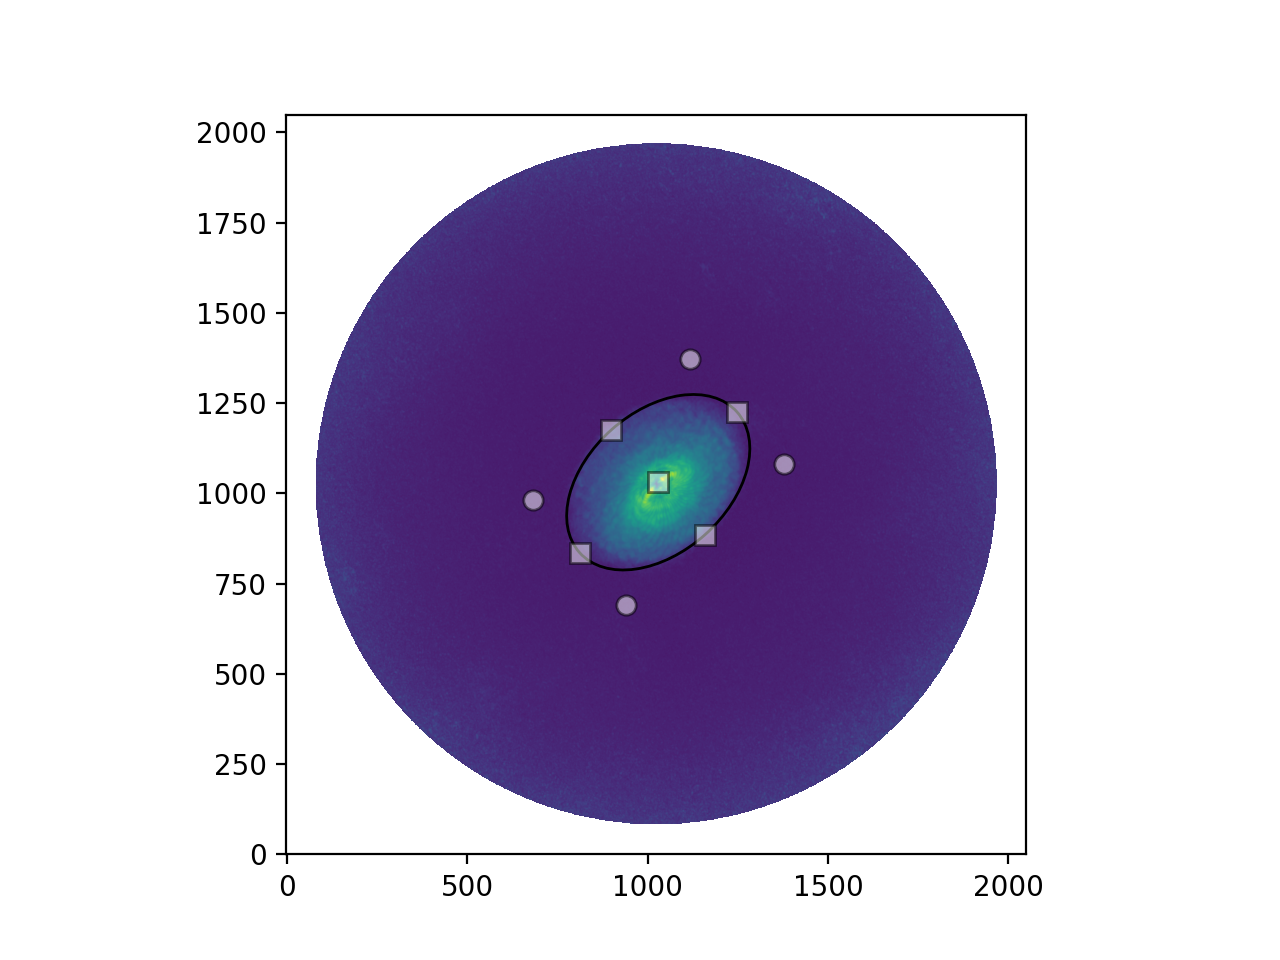

In [10]:
fig = pl.figure()
ax = fig.add_subplot()
ax.imshow(mx.value, origin='lower')

We can draw an ellipse around the disk to downselect only it:

In [12]:
import regions

In [13]:
center = regions.PixCoord(1000, 1000)
ellipse = regions.EllipsePixelRegion(center, width=600, height=600, angle=45*u.deg)
selector = ellipse.as_mpl_selector(ax, sync=True, use_data_coordinates=True)

The `selector` has created a link to an interactive matplotlib widget that allows us to manually scale the ellipse, by dragging the points of the surrounding box, and position it via the central point. Pressing `r` toggles the rotation mode for the corner points; keeping `ctrl` pressed will resize around the center, providing better control of the selector position. We can investigate the ellipse parameters once having drawn it to a satisfactory fit:

In [14]:
print(ellipse.center, ellipse.angle)
print(ellipse.bounding_box)

PixCoord(x=1029.7107130138534, y=1030.6062285798141) 41.81857594111824 deg
BoundingBox(ixmin=776, ixmax=1284, iymin=788, iymax=1275)


We make a cutout by creating a subcube using the ellipse region as a mask:

In [15]:
cutout = cube.subcube_from_regions([ellipse])
cutout

DaskSpectralCube with shape=(127, 486, 508) and unit=Jy / beam and chunk size (127, 250, 260):
 n_x:    508  type_x: RA---SIN  unit_x: deg    range:   269.087105 deg:  269.090142 deg
 n_y:    486  type_y: DEC--SIN  unit_y: deg    range:   -21.957600 deg:  -21.954905 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

Then we want to extract a position-velocity diagram across the disk.

We specify a width of 200 pixels (we could go to ~400) so we average across the short axis of the disk (note that `n_x` and drawn it to `n_y` are passed to `Path` in inverse order):

In [17]:
import pvextractor

In [18]:
path = pvextractor.Path([(0,0), cutout.shape[:0:-1]], width=250)

We show the path overlaid on our cutout disk:

<IPython.core.display.Javascript object>


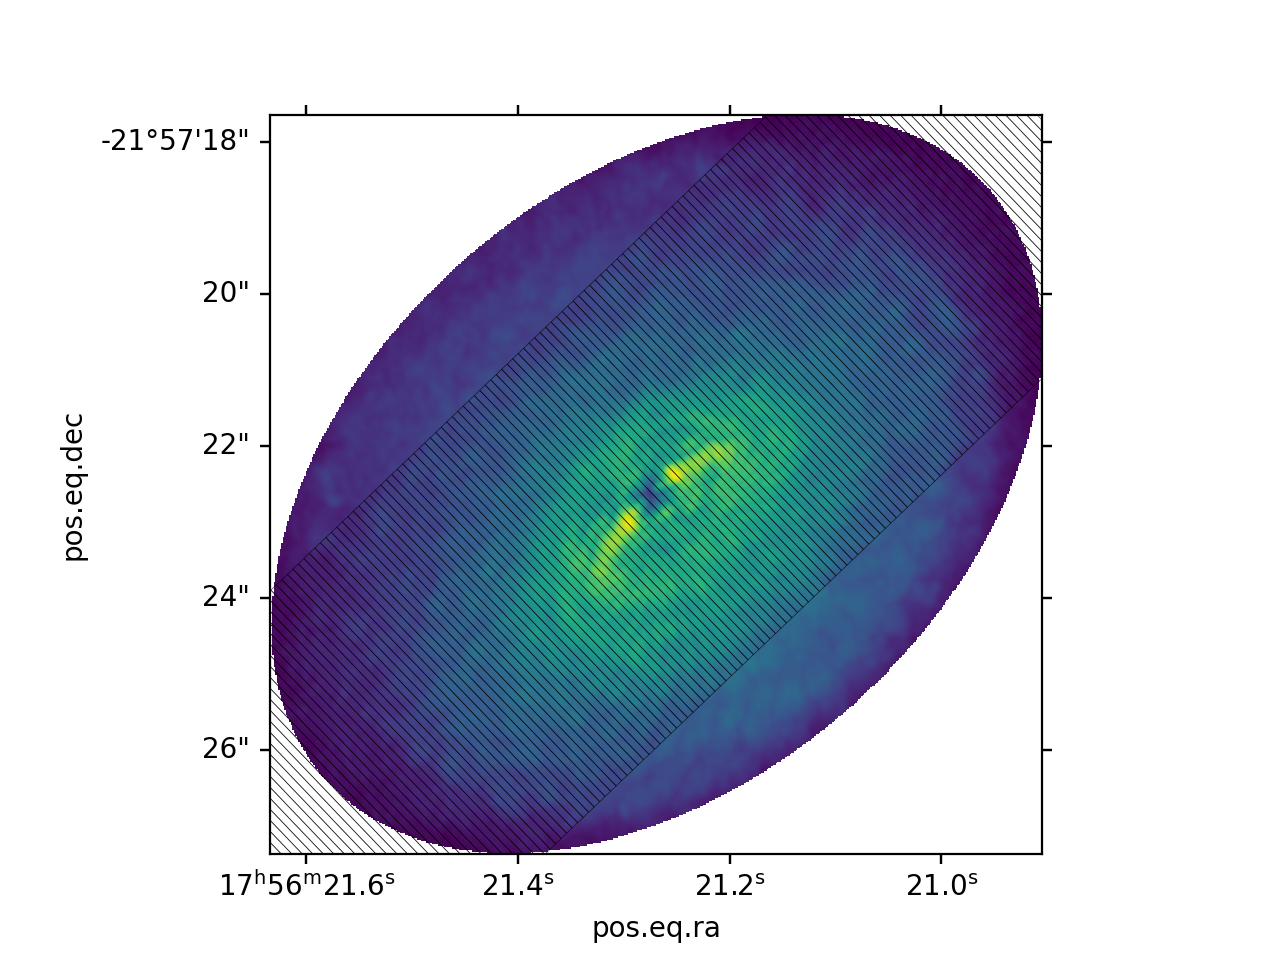

In [19]:
fig2 = pl.figure(2)
ax = fig2.add_subplot(111, projection=cutout.wcs.celestial)
ax.imshow(cutout.max(axis=0).value, origin='lower')
path.show_on_axis(ax, spacing=5, alpha=0.7, linewidth=0.25)

Then, we extract the PV diagram.  We choose spacing=5 to average over 5 pixels.  This averaging isn't necessary, but does make the operation a little faster and increases the signal-to-noise ratio per spatial bin.

In [21]:
pv = pvextractor.extract_pv_slice(cutout.with_spectral_unit(u.km/u.s, velocity_convention='radio'), path, spacing=5)

And plot the resulting diagram:

<IPython.core.display.Javascript object>


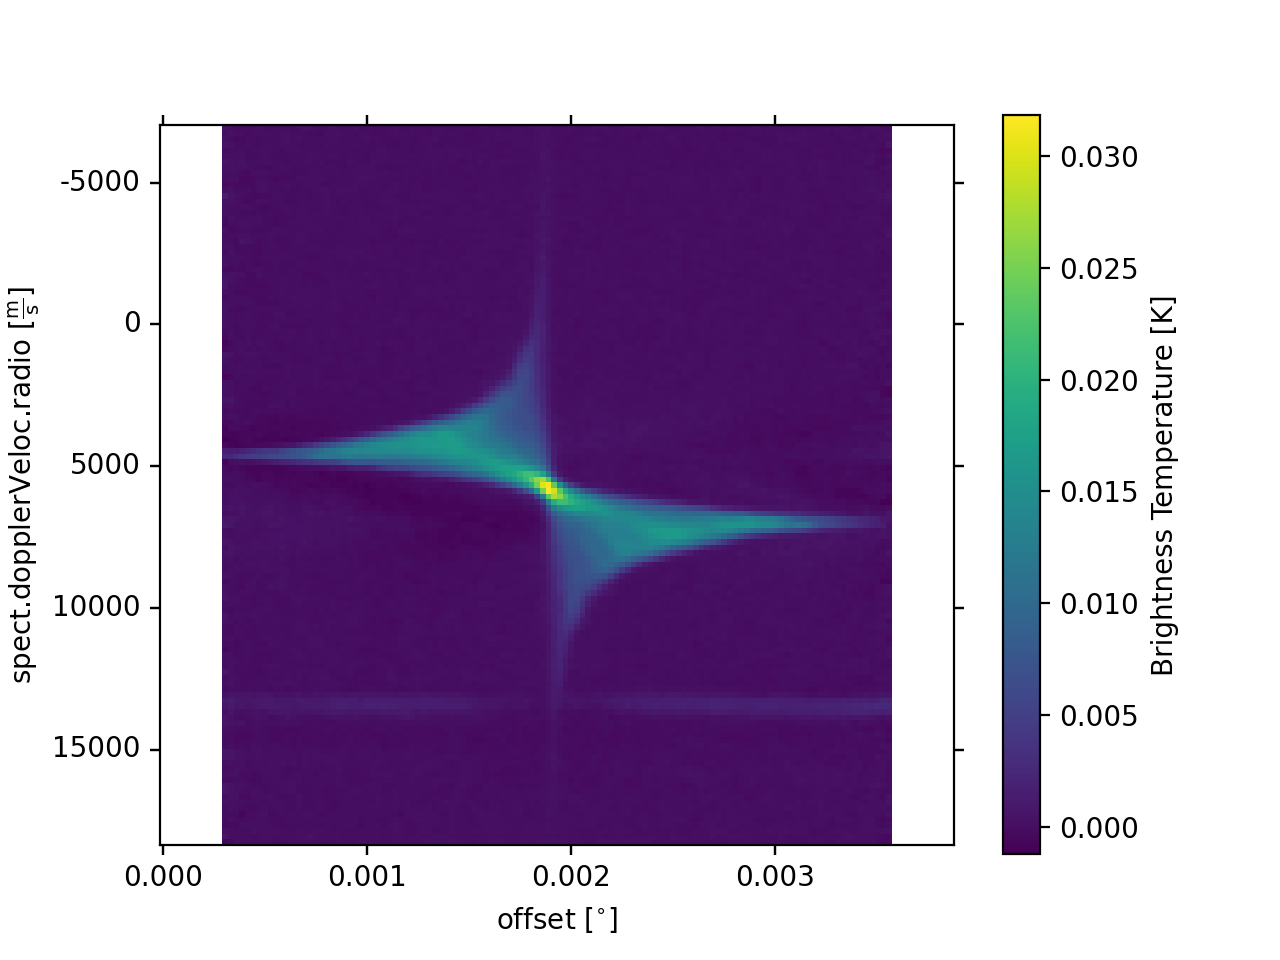

In [22]:
fig3 = pl.figure(3)
ax = fig3.add_subplot(111, projection=wcs.WCS(pv.header))
im = ax.imshow(pv.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")
ax.set_aspect(1)

# Second approach

We can also reproject the whole cube by rotating 45 degrees.

This requires making our own new header, which is a bit tedious, but effective.

In [ ]:
header = cutout.wcs.to_header()
header['NAXIS'] = 3
header['NAXIS1'] = 600
header['NAXIS2'] = 400
header['NAXIS3'] = cutout.shape[0]
angle = 45*u.deg
header['CD1_1'] = np.cos(angle).value * np.abs(cube.wcs.wcs.cdelt[0])
header['CD2_1'] = -np.sin(angle).value * np.abs(cube.wcs.wcs.cdelt[0])
header['CD1_2'] = np.sin(angle).value * np.abs(cube.wcs.wcs.cdelt[1])
header['CD2_2'] = np.cos(angle).value * np.abs(cube.wcs.wcs.cdelt[1])
header['CD3_3'] = cube.wcs.wcs.cdelt[2]
header['CRPIX1'] = 300
header['CRPIX2'] = 200

We then reproject the whole cube, which takes a minute or two:

In [ ]:
reproj = cutout.reproject(header)

In [ ]:
reproj

In [ ]:
rmax = reproj.max(axis=0)

In [ ]:
rmax.quicklook()

Then, the position-velocity diagram is easy: we just take the average along the short axis:

In [ ]:
pv2 = reproj.with_spectral_unit(u.km/u.s, velocity_convention='radio').mean(axis=1)

In [ ]:
ax = pl.subplot(111, projection=wcs.WCS(pv2.header))
im = ax.imshow(pv2.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")
ax.set_aspect(4)